# VQE with Multi-Model Bayesian Optimisation: One Surrogate per Observable
### Estimation of ground state energy, Hamiltonian Hydrogen $H_{2}$

In [1]:
#Import libraries
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from math import pi
import matplotlib.pylab as plt
from itertools import product
from qiskit.quantum_info import Operator
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_bo import *

from scipy.linalg import eigh
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock


In [2]:
#Setting up the H2 molecule
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

problem = driver.run()

#Obtaining the Hamiltonian
hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()


#Converting to qubit Hamiltonian
mapper = JordanWignerMapper()
H = mapper.map(second_q_op)


nuclear_repulsion_energy = hamiltonian.nuclear_repulsion_energy

hamiltonian.electronic_integrals.alpha += PolynomialTensor({"": nuclear_repulsion_energy})
mapper = JordanWignerMapper()
second_q_op = hamiltonian.second_q_op()
H = mapper.map(second_q_op)


Initial state: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))
Initial Circuit Ansatz


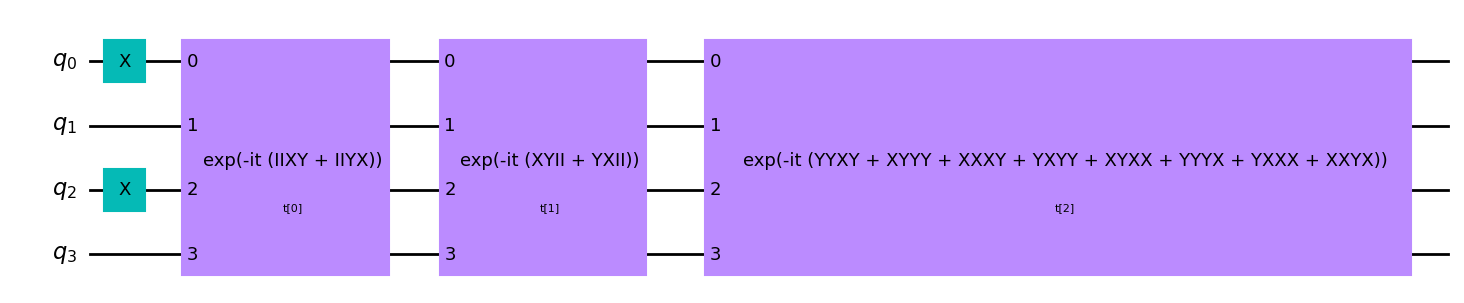

In [3]:
# Set up the UCCSD ansatz for H2
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles
mapper = JordanWignerMapper()

initial_state = HartreeFock(
    num_spatial_orbitals,
    num_particles,
    mapper
)

uccsd = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    qubit_mapper=mapper,
    initial_state=initial_state
)
num_qubits = uccsd.num_qubits
print('Initial state:',Statevector.from_instruction(initial_state))
initial_circuit = uccsd.decompose()
print('Initial Circuit Ansatz')
initial_circuit.draw('mpl')

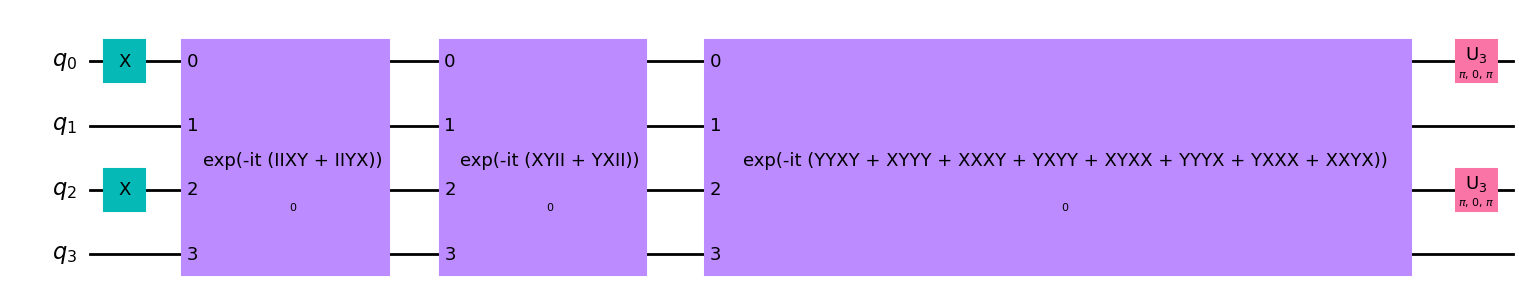

In [4]:
def create_circuit_uccsd(thetas, initial_state):
    thetas = thetas.squeeze()
    # Create circuit
    circ = QuantumCircuit(uccsd.num_qubits)

    # Apply the initial state (HartreeFock)
    circ.compose(initial_state, inplace=True)

    # Generate initial random parameters
    num_parameters = uccsd.num_parameters
    #thetas = np.random.random(num_parameters)

    # Apply the UCCSD ansatz with the generated parameters
    circ = uccsd.assign_parameters(thetas).compose(circ)

    return circ

n_thetas = uccsd.num_parameters
circ_visualization = create_circuit_uccsd(np.zeros(n_thetas)[np.newaxis,:], initial_state)
circ_visualization.decompose().draw('mpl')

In [5]:
eigenvalues, eigenvectors = eigh(H.to_matrix())
ground_state_energy = np.min(eigenvalues)
ground_state = eigenvectors[:, np.argmin(eigenvalues)]
print(f"Ground state energy: {ground_state_energy}")

Ground state energy: -1.1373060357534004


In [6]:
circuit = create_circuit_uccsd
n_surrogates_models = len(H.coeffs)

#If you want to estimate the performance with a set of test of the surrogate models, it is recommended to use the lines that contain the word "test"
#they are commented to reduce the computational cost.
#n_test_samples = 100
#X_test, y_test_expectation_values, y_test_sum_expectation_values = get_real_samples_vqe(circuit, n_test_samples, n_thetas, initial_state, H, type_sampling = 'Random_Uniform')


Main parameters of the BO

In [7]:
#Generate initial samples
n_initial_samples = 1
#Number of time to run the BO
n_run = 2

#Number of iterations of one BO
n_BO = 200

#Parameter of the function of adquisicion
beta = 1

In [8]:
#BO loop
#Percentage of data to keep to train the degenerated GP. 0.1->10%  of the new 
history_best_eigenvalue_runs = np.zeros((n_run,n_BO))
best_eigenvalue_runs = np.zeros(n_run)
best_thetas_runs = np.zeros((n_run, n_thetas))

n_samples_acquisition_fx = 1000

#Parameters of the GPs
params = {'training_iter': 10, 'learning_rate':0.1, 'initial_noise':1e-8, 'initial_lengthscale':0.9, 'initial_output_scale': 1, 'scaler_target': None, #'StandardScaler',
                'verbose':False }
bounds = torch.stack([torch.zeros(n_thetas), 2*pi*torch.ones(n_thetas)])  #Bounds angles  


for iter_run in range(n_run):
    print('run ', iter_run+1)
    X_initial_thetas, y_initial_expectation_values, y_initial_eigenvalues = get_real_samples_vqe(circuit, n_initial_samples, n_thetas, initial_state, H, type_sampling = 'LHS')


    history_best_eigenvalue = []
    keys = (['mean_MSE_eigenvalue_train', 'mean_MSE_eigenvalue_test'] +
            ['mean_loss_train_sm_'+str(n_sm) for n_sm in range(n_surrogates_models)]+
            ['mean_loss_test_sm_'+str(n_sm) for n_sm in range(n_surrogates_models)])
    mean_metrics = {key: np.zeros(n_BO) for key in keys}

    history_thetas = np.zeros((n_BO,n_thetas))

    #Store real data
    X_train, y_train_expectations_values, y_train_eigenvalues = X_initial_thetas, y_initial_expectation_values, y_initial_eigenvalues

    #train model and save variables of training
    surrogate_models, metrics_models = {'gp_model':[], 'likelihood':[], 'scaler_target':[]}, {}
    for n_sm in range(n_surrogates_models):
        gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_expectations_values[:,n_sm], [], [], params))
        #gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_eigenvalues, [], [], params))
        surrogate_models['gp_model'].append(gp_model)
        surrogate_models['likelihood'].append(ll)
        surrogate_models['scaler_target'].append(scaler_y)
        metrics_models['model_train_'+str(n_sm)] = metrics['loss_train'][-1]
        #metrics_models['model_test_'+str(n_sm)] = metrics['loss_test'][-1]


    #Best eigenvalue
    idx_best_eigenvalue = np.argmax(y_initial_eigenvalues)
    best_eigenvalue = y_train_eigenvalues[idx_best_eigenvalue]
    best_thetas = X_train[idx_best_eigenvalue]
    history_best_eigenvalue.append(-best_eigenvalue)


    mean_estimated_eigenvalues_train,std_estimated_eigenvalues_train = get_eigenvalues_from_expectations_values(surrogate_models, X_train, np.ones(n_surrogates_models), num_qubits)  
    #mean_estimated_eigenvalues_test,std_estimated_eigenvalues_test = get_eigenvalues_from_expectations_values(surrogate_models, X_test, np.ones(n_surrogates_models), num_qubits)  
    iter_BO = 0
    mean_metrics['mean_MSE_eigenvalue_train'][iter_BO] = np.mean((mean_estimated_eigenvalues_train - y_train_eigenvalues)**2)
    #mean_metrics['mean_MSE_fidelity_test'][iter_BO] = np.mean((mean_estimated_fidelities_test - y_test_fidelities)**2)
    for n_sm in range(n_surrogates_models):
        mean_metrics['mean_loss_train_sm_'+str(n_sm)][iter_BO] = metrics_models['model_train_'+str(n_sm)]
        #mean_metrics['mean_loss_test_sm_'+str(n_sm)][iter_BO] = metrics_models['model_test_'+str(n_sm)]



    pbar = tqdm(range(1, n_BO))
    for iter_BO in pbar:
        # Generate new angles samples
        wrapped_gp_model = WrappedGPyTorchModelMultiGPHamiltonian(surrogate_models, np.ones(n_surrogates_models), num_qubits)
        #wrapped_gp_model = WrappedGPyTorchModelMonoGP(gp_model)

        fx_acq = UpperConfidenceBound(wrapped_gp_model, beta = beta)
        fx_acq.model.eval()

        candidate, acq_value = optimize_acqf(
            acq_function=fx_acq,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=n_samples_acquisition_fx,
        )
        
        new_sample = np.array(candidate).squeeze(0)

        new_exp_values, new_eigenvalue = get_expectation_values_hamiltonian(circuit, new_sample[np.newaxis,:], initial_state, H)

        #Add new data to known X_theta, y_real_expectation_values and y_real_fidelity
        X_train = np.vstack((X_train,new_sample[np.newaxis,:]))
        y_train_eigenvalues = np.hstack((y_train_eigenvalues, new_eigenvalue))
        y_train_expectations_values = np.vstack((y_train_expectations_values, new_exp_values))

        #Check if the new eigenvalue is best than the current best eigenvalue
        if new_eigenvalue>best_eigenvalue:
            best_eigenvalue = new_eigenvalue
            best_thetas = new_sample
            
        history_best_eigenvalue.append(-best_eigenvalue)
        history_thetas[iter_BO] = -best_thetas

        #Update the models
        surrogate_models, metrics_models = {'gp_model':[], 'likelihood':[], 'scaler_target':[]}, {}

        for n_sm in range(n_surrogates_models):
            gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_expectations_values[:,n_sm], [], [], params))
            #gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_eigenvalues, [], [], params))

            surrogate_models['gp_model'].append(gp_model)
            surrogate_models['likelihood'].append(ll)
            surrogate_models['scaler_target'].append(scaler_y)
            metrics_models['model_train_'+str(n_sm)] = metrics['loss_train'][-1]
            #metrics_models['model_test_'+str(n_sm)] = metrics['loss_test'][-1]
        
        
        mean_estimated_eigenvalues_train, std_estimated_eigenvalues_train = get_eigenvalues_from_expectations_values(surrogate_models, X_train, np.ones(n_surrogates_models), num_qubits)  
        #mean_estimated_eigenvalues_test, std_estimated_eigenvalues_test = get_eigenvalues_from_expectations_values(surrogate_models, X_test, np.ones(n_surrogates_models), num_qubits)  
        mean_metrics['mean_MSE_eigenvalue_train'][iter_BO] = np.mean((mean_estimated_eigenvalues_train - y_train_eigenvalues)**2)
        #mean_metrics['mean_MSE_fidelity_test'][iter_BO] = np.mean((mean_estimated_fidelities_test - y_test_fidelities)**2)
        for n_sm in range(n_surrogates_models):
            mean_metrics['mean_loss_train_sm_'+str(n_sm)][iter_BO] = metrics_models['model_train_'+str(n_sm)]
            #mean_metrics['mean_loss_test_sm_'+str(n_sm)][iter_BO] = metrics_models['model_test_'+str(n_sm)]


        pbar.set_description('Current best eigenvalue {}'.format(np.round(-best_eigenvalue, 9)))


    history_best_eigenvalue_runs[iter_run] = history_best_eigenvalue
    best_eigenvalue_runs[iter_run] = -best_eigenvalue
    best_thetas_runs[iter_run] = -best_thetas




run  1


  0%|          | 0/199 [00:00<?, ?it/s]

run  2


  0%|          | 0/199 [00:00<?, ?it/s]

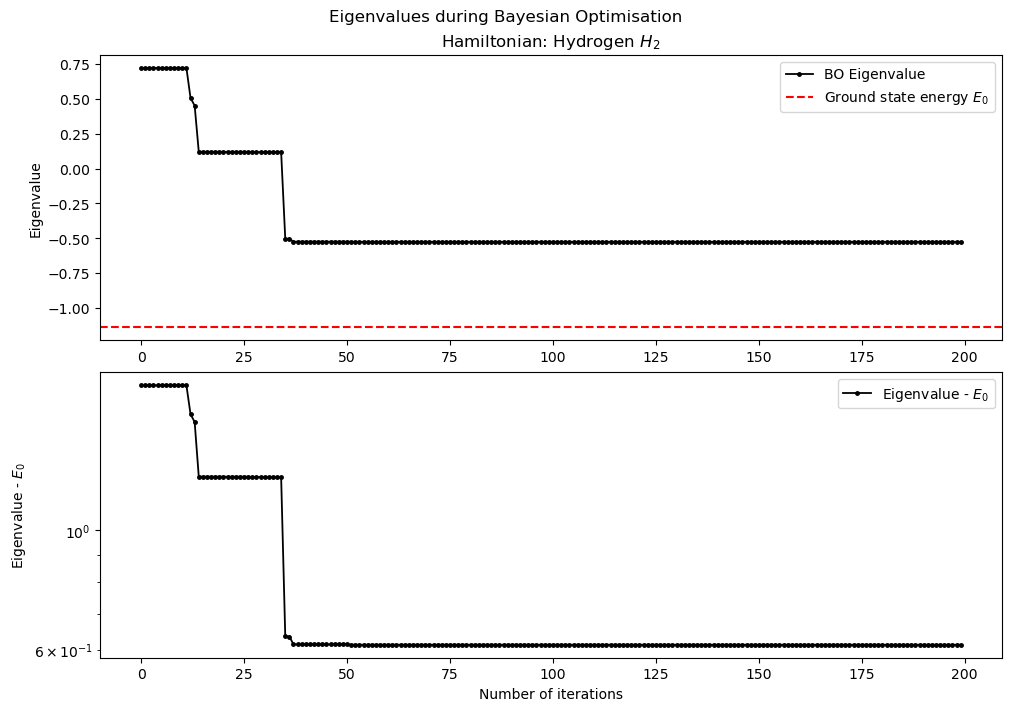

In [9]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during Bayesian Optimisation')

ax[0].set_title(r'Hamiltonian: Hydrogen $H_{2}$')
ax[0].plot(np.arange(n_BO), np.mean(history_best_eigenvalue_runs,0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'BO Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_BO), np.mean(history_best_eigenvalue_runs,0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')

ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.legend()
plt.show()

In [10]:
#Save data generated
data_plot = {   'history_best_eigenvalue_runs':history_best_eigenvalue_runs,
                'best_thetas_runs': best_thetas_runs,
                'best_eigenvalue_runs':best_eigenvalue_runs, 
                'n_samples_acquisition_fx':n_samples_acquisition_fx,
                'n_BO': n_BO,
                'learning_rate': params['learning_rate'],
                'initial_noise': params['initial_noise'],
                'scaler_target': params['scaler_target'],
                'n_initial_samples': n_initial_samples,
                'mean_MSE_eigenvalue_train':mean_metrics['mean_MSE_eigenvalue_train'],
                'mean_MSE_eigenvalue_test':mean_metrics['mean_MSE_eigenvalue_test'],
                'real_ground_state_energy':ground_state_energy,
                'type_acq_function': str(fx_acq),
                'H_matrix':H.to_matrix(),
                'H_coeffs':H.coeffs,
                 
             }

if True:
    with open("../results/vqe/results_hamiltonian_hydrogen_H2_"+ str(num_qubits)+"qubits_bo_observables.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)
    

In [11]:
metrics_reg= {
    'mean_eigenvalue_runs': -np.mean(np.abs(best_eigenvalue_runs)),
    'std_eigenvalue_runs': np.std(best_eigenvalue_runs),
        }

params['size_final_dataset'] = y_initial_eigenvalues.shape[0]
params['n_samples_acquisition_fx'] = n_samples_acquisition_fx
params['type_acq_function'] = str(fx_acq)
params['n_initial_samples'] = n_initial_samples


Optionally: Track metrics and parameters in MLflow

In [12]:
import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VQE_H2")

with mlflow.start_run(run_name='VQE_H2_BO_Observables'):

    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)

2024/09/22 14:25:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run VQE_H2_BO_Observables at: http://127.0.0.1:8080/#/experiments/839549506925561708/runs/4267833b503041c5a52e8a11f47b8d89.
2024/09/22 14:25:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839549506925561708.
